# RSA

for more cool stuff, see  
- https://naturalistic-data.org/content/Intersubject_RSA.html
- https://dartbrains.org/content/RSA.html

In [1]:
import os
import glob

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns

from scipy.stats import rankdata, ttest_1samp

import nibabel as nib

from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from sklearn.metrics import pairwise_distances

from nilearn import datasets, plotting
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img_on_surf, view_img, view_img_on_surf
from nilearn.input_data import NiftiLabelsMasker

# ignore warnings - if you want to reset, run warnings.resetwarnings()
import warnings
warnings.simplefilter('ignore',UserWarning)

/home/anakin/miniconda3/envs/slab_fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# we will work with the zstat files output by 2nd level, that is one for each condition for each subject
# initialize data
data_dir = r'/home/anakin/Desktop/ds000113/output/2nd_level/'
num_of_subjects = 10 
excluded = [7,8]
subject_list = ["{:02d}".format(i) for i in range(1,num_of_subjects+1) if i not in excluded]
cond_list = ['normdiff','shot','face','rms','speech','gaze','touch','affect','general']
cond_files = [i for i in range(len(cond_list))]
# single subject check
sub = subject_list[0]
file_list = []
for i in range(len(cond_list)):
    file_list.append(os.path.join(data_dir,sub,'fixed_effects',sub,f'_fixed_eff_model{i}','zstat1.nii.gz'))
beta = Brain_Data(file_list)
# check for order
for i in file_list:
    print(i)

/home/anakin/Desktop/ds000113/output/2nd_level/01/fixed_effects/01/_fixed_eff_model0/zstat1.nii.gz
/home/anakin/Desktop/ds000113/output/2nd_level/01/fixed_effects/01/_fixed_eff_model1/zstat1.nii.gz
/home/anakin/Desktop/ds000113/output/2nd_level/01/fixed_effects/01/_fixed_eff_model2/zstat1.nii.gz
/home/anakin/Desktop/ds000113/output/2nd_level/01/fixed_effects/01/_fixed_eff_model3/zstat1.nii.gz
/home/anakin/Desktop/ds000113/output/2nd_level/01/fixed_effects/01/_fixed_eff_model4/zstat1.nii.gz
/home/anakin/Desktop/ds000113/output/2nd_level/01/fixed_effects/01/_fixed_eff_model5/zstat1.nii.gz
/home/anakin/Desktop/ds000113/output/2nd_level/01/fixed_effects/01/_fixed_eff_model6/zstat1.nii.gz
/home/anakin/Desktop/ds000113/output/2nd_level/01/fixed_effects/01/_fixed_eff_model7/zstat1.nii.gz
/home/anakin/Desktop/ds000113/output/2nd_level/01/fixed_effects/01/_fixed_eff_model8/zstat1.nii.gz


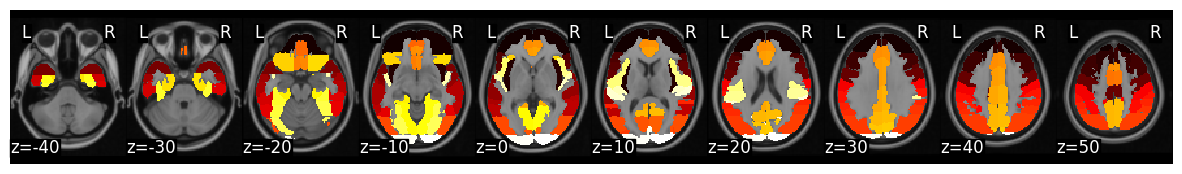

In [3]:
# since every atlas is ordered differently, we will use the one in data folder - this time the lateralized version
# for ROI dictionary, see xml file
mask = Brain_Data('data/HarvardOxford-cortl-maxprob-thr25-2mm.nii.gz')
mask_x = expand_mask(mask) # binarize probability atlas
mask.plot()

In [4]:
# compute correlations of conditions across all ROIs
out = []
for m in mask_x:
    out.append(beta.apply_mask(m).distance(metric='correlation'))

/home/anakin/miniconda3/envs/slab_fmri/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


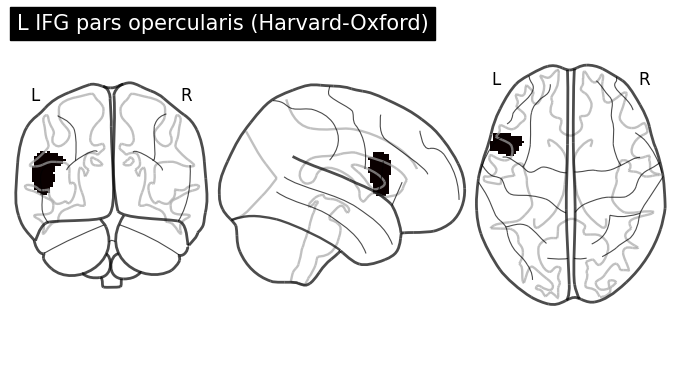

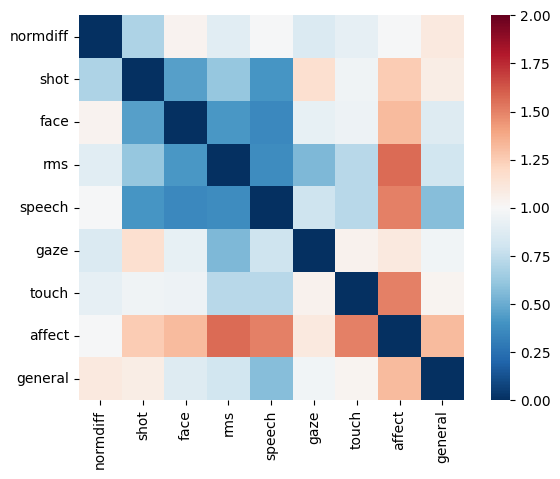

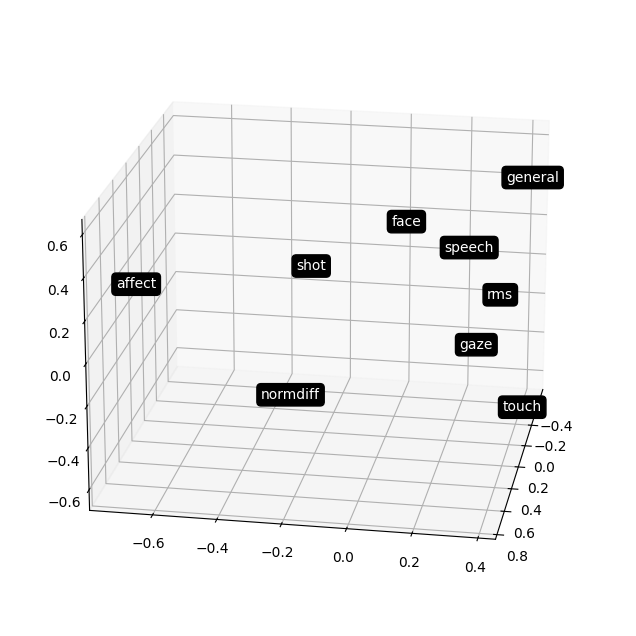

In [5]:
# plot an example ROI and it’s associated distance matrix and projected distance in 3 dimensions
roi = 10 # Left Inferior Frontal Gyrus, pars opercularis
roi_name = 'L IFG pars opercularis (Harvard-Oxford)'

plot_glass_brain(mask_x[roi].to_nifti(),title = roi_name)

out[roi].labels = cond_list
f1 = out[roi].plot(vmin=0, vmax=2, cmap='RdBu_r')
f2 = out[roi].plot_mds(n_components=3, view=(20, 10))

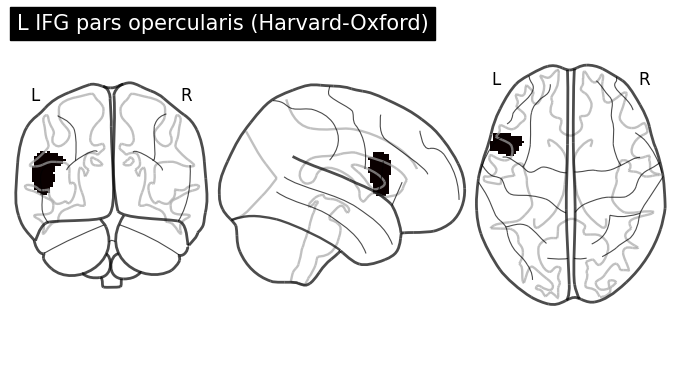

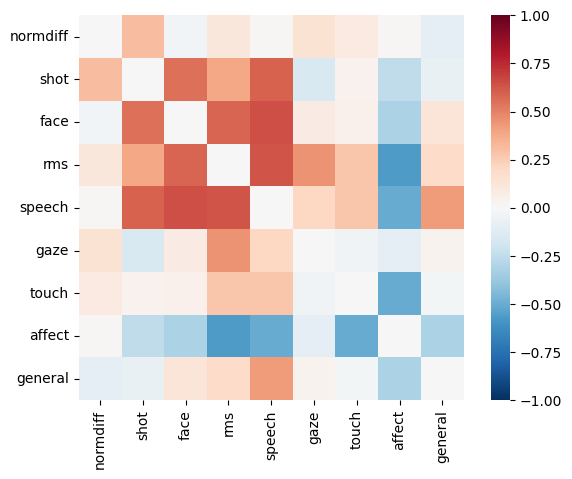

In [6]:
# just to make this slightly more intuitive to understand what is going on we will convert this to similarity. 
# For correlation based distance, this entails subtracting each value from 1. 
# This will yield similarity scores in the form of pearson correlations. 
# If you are using unbounded metrics (e.g., euclidean distance), then use the distance_to_similarity() Adjacency method.

out_sim = []
for m in out:
    mask_tmp = m.copy()
    mask_tmp = 1 - mask_tmp
    mask_tmp.labels = cond_list
    out_sim.append(mask_tmp)
    
plot_glass_brain(mask_x[roi].to_nifti(),title = roi_name)
# this time we will plot the similarity (1 - correlation based distance)
f = out_sim[roi].plot(vmin=-1, vmax=1, cmap='RdBu_r')

In [7]:
# Testing a Representation Hypothesis
# let’s create an adjacency matrix indicating a specific relationship between conditions.
# This type of adjacency matrix is one way in which we can test a specific hypotheses about the representational 
# structure of the data across all images.

Text(0.5, 1.0, 'visual')

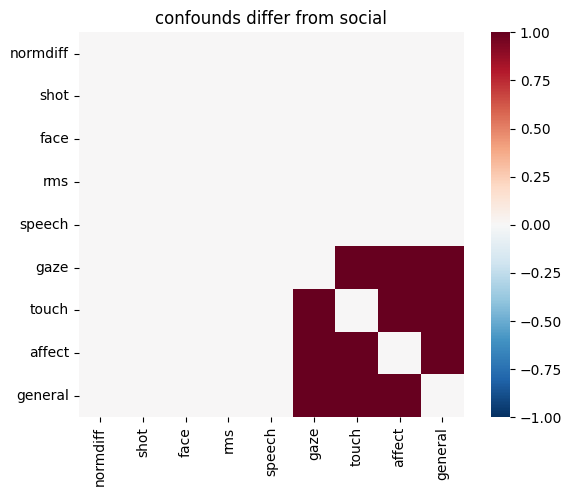

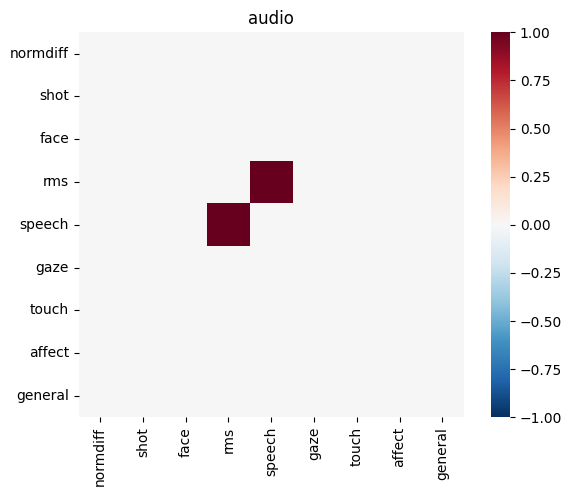

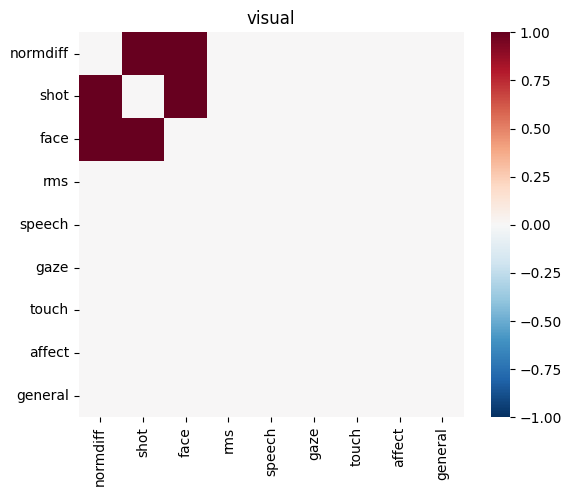

In [8]:
# we will plot each model's RDM, note the diagonal will apear to be 0 but we will use the Adjacancy class
# which extracts the lower triangle of the matrix - without it's diagonal
# confounds vs social
con_social= np.zeros((len(cond_list),len(cond_list)))
con_social[np.diag_indices(len(cond_list))] = 1 
con_social[5,6] = 1
con_social[5,7] = 1
con_social[5,8] = 1
con_social[6,5] = 1
con_social[6,7] = 1
con_social[6,8] = 1
con_social[7,5] = 1
con_social[7,6] = 1
con_social[7,8] = 1
con_social = Adjacency(con_social, matrix_type='similarity', labels=cond_list)

con_social.plot(cmap='RdBu_r',vmin=-1)
plt.title('confounds differ from social')
# audio-visual

# audio  
audio = np.zeros((len(cond_list),len(cond_list)))
audio[np.diag_indices(len(cond_list))] = 1 
audio[3,4] = 1
audio[4,3] = 1
audio = Adjacency(audio, matrix_type='similarity', labels=cond_list)
audio.plot(cmap='RdBu_r',vmin=-1)
plt.title('audio')

# visual
visual = np.zeros((len(cond_list),len(cond_list)))
visual[np.diag_indices(len(cond_list))] = 1 
visual[0,1] = 1
visual[0,2] = 1
visual[1,2] = 1
visual[1,2] = 1
visual[2,0] = 1
visual[2,1] = 1

visual = Adjacency(visual, matrix_type='similarity', labels=cond_list)
visual.plot(cmap='RdBu_r',vmin=-1)
plt.title('visual')

In [9]:
# group RSA inference
# Here we calculate the RSA for each ROI for every participant. 
# This will take a little bit of time to run.

# initialize a group similiraity dictionary of actual responses and distances
all_sub_similarity = {}; all_sub_distance = {};
# initialize a group similiraity dictionary of models
all_sub_con_social_rsa = {}; all_sub_audio_rsa = {}; all_sub_visual_rsa = {};

# loop over each subject
for i,sub in enumerate(subject_list):
    print(f'calculating similarity of sub-{sub}...')
    file_list = []
    # grab individual model fits of all conditions
    for j in range(len(cond_list)):
        file_list.append(os.path.join(data_dir,sub,'fixed_effects',sub,f'_fixed_eff_model{j}','zstat1.nii.gz'))
    # create a brain data object with all condition betas
    beta = Brain_Data(file_list)
    # initialize individual subject's actual response pattern (and distances) list of all ROIs 
    sub_pattern = []; sub_dis = [];
    # initialize individual subject's model fit lists of all ROIs
    con_social_sim_r = []; audio_sim_r = []; visual_sim_r = []
    
    # loop over ROIs
    for m in mask_x:
        # compute similarity of conditions within ROIsub_pattern
        sub_pattern_similarity = 1 - beta.apply_mask(m).distance(metric='correlation')
        sub_pattern_dis = beta.apply_mask(m).distance(metric='correlation') 
        sub_pattern_similarity.labels = cond_list
        # compute correlation of response and model within ROI
        # model 1 - social
        s1 = sub_pattern_similarity.similarity(con_social, metric='spearman', n_permute=0)
        con_social_sim_r.append(s1['correlation'])
        # model 2 - audio
        s2 = sub_pattern_similarity.similarity(audio, metric='spearman', n_permute=0)
        audio_sim_r.append(s2['correlation'])
        # model 3 - visual
        s3 = sub_pattern_similarity.similarity(visual, metric='spearman', n_permute=0)
        visual_sim_r.append(s3['correlation'])
        # append pattern similarity
        sub_pattern.append(sub_pattern_similarity)
        sub_dis.append(sub_pattern_dis)
        
    # append individual subjects data
    all_sub_distance[i] = sub_dis
    all_sub_similarity[i] = sub_pattern
    all_sub_con_social_rsa[i] = con_social_sim_r
    all_sub_audio_rsa[i] = audio_sim_r
    all_sub_visual_rsa[i] = visual_sim_r
    
# create a pandas dataframe for models
# distances and similarities are stored as lists of dictionaries     
all_sub_con_social_rsa = pd.DataFrame(all_sub_con_social_rsa).T
all_sub_audio_rsa = pd.DataFrame(all_sub_audio_rsa).T
all_sub_visual_rsa = pd.DataFrame(all_sub_visual_rsa).T

calculating similarity of sub-01...
calculating similarity of sub-02...
calculating similarity of sub-03...
calculating similarity of sub-04...
calculating similarity of sub-05...
calculating similarity of sub-06...
calculating similarity of sub-09...
calculating similarity of sub-10...


In [30]:
# to access the data of a nilearn instance:
print(all_sub_distance[i][roi].data)

# to access the model correlation, use as pandas dataframe. 
# columns are ROIs, rows are subjects, numbers represent correlation to model
all_sub_visual_rsa.head

[1.60871216 1.53776424 1.53134294 1.24417497 1.52551574 1.1020021
 1.08705026 0.70441586 0.63989404 0.49701341 0.73242408 0.554655
 0.66925806 1.02135095 1.27548135 0.31835171 0.53075868 0.68808805
 1.06316964 1.10292699 1.11076778 0.58892675 0.38687935 1.13185506
 1.31729353 1.13629132 0.66740153 0.69518097 0.77959355 1.20612202
 1.18882062 0.76790627 1.6195256  0.68123471 1.26902964 1.74634343]


<bound method NDFrame.head of          0         1         2         3         4         5         6   \
0  0.343452  0.285404  0.285404 -0.091910  0.440199  0.275729  0.382151   
1 -0.111259  0.082235  0.372476  0.101584 -0.140283  0.043536 -0.072560   
2  0.024187  0.208006 -0.198332  0.266055 -0.091910 -0.130609 -0.159633   
3  0.111259  0.033861 -0.053211 -0.130609  0.004837 -0.178982  0.072560   
4  0.217681  0.237030 -0.101584 -0.091910  0.014512  0.256380  0.082235   
5  0.198332  0.149958  0.072560  0.043536  0.149958  0.266055  0.033861   
6 -0.149958 -0.130609  0.043536 -0.149958 -0.111259 -0.062886 -0.208006   
7  0.033861  0.111259 -0.198332 -0.149958  0.033861  0.130609 -0.101584   

         7         8         9   ...        86        87        88        89  \
0  0.091910  0.285404  0.188657  ... -0.072560  0.033861  0.014512  0.014512   
1  0.072560 -0.159633  0.024187  ...  0.140283  0.149958 -0.024187 -0.178982   
2  0.091910 -0.053211 -0.149958  ... -0.014512  0.0145

Text(0.5, 1.0, 'Distribution of rho across subjects in \nL IFG pars opercularis (Harvard-Oxford) for audio model')

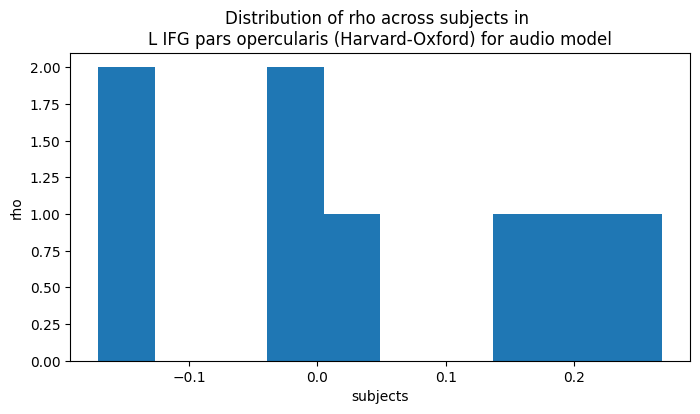

In [11]:
# lets look at a specific ROI and the audio RSA score (rho) distribution
plt.figure(figsize =(8,4))
plt.hist(all_sub_audio_rsa[roi])
plt.ylabel('rho')
plt.xlabel('subjects')
plt.title(f'Distribution of rho across subjects in \n{roi_name} for audio model',fontsize = 12)

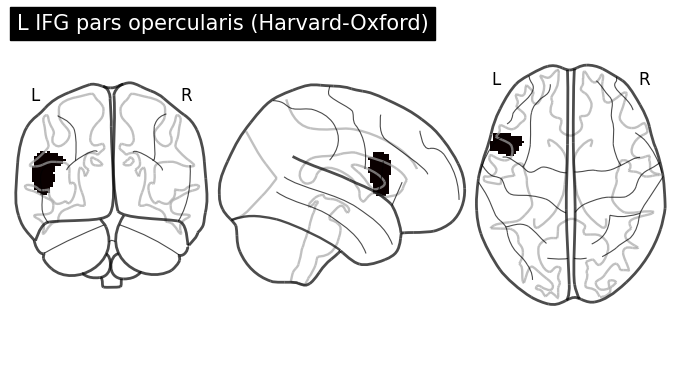

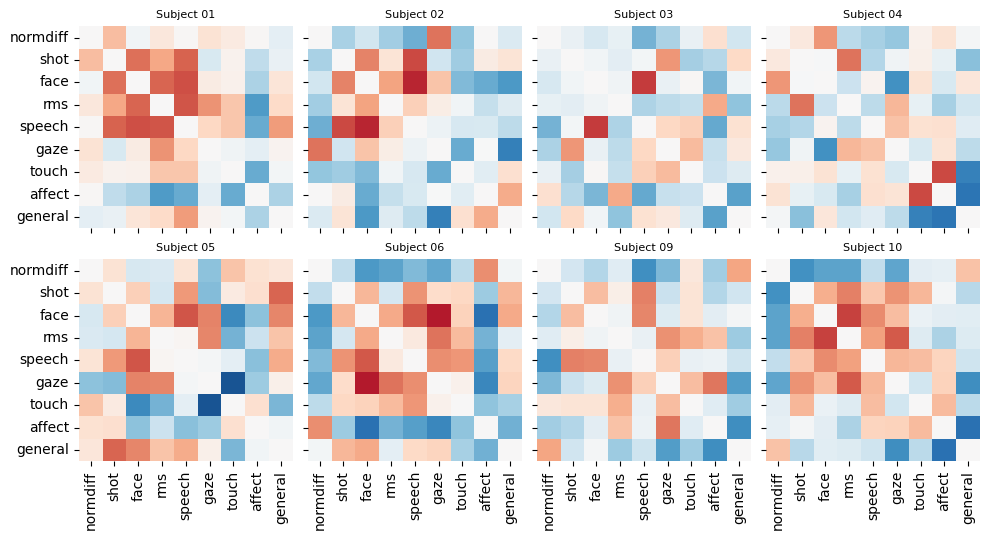

In [12]:
# plotting single-subjects similarity matrices of conditions (based on model fit) ofor a selected ROI 
plot_glass_brain(mask_x[roi].to_nifti(),title=roi_name)
f,a = plt.subplots(nrows=2, ncols=4, figsize=(10,5.5),sharex=True,sharey=True)
counter = 1
roi = 1 # change according to ROI that you want to view
for row in range(a.shape[0]):
    for col in range(a.shape[1]):
        #plt.figure()
        sns.heatmap(all_sub_similarity[counter-1][roi].squareform(), cbar=False,
                    ax=a[row, col], cmap='RdBu_r',xticklabels=cond_list, yticklabels=cond_list,
                    vmax=1,vmin=-1,#annot=True, fmt=".1f",
                    annot_kws={"fontsize":4})
        a[row,col].set_title(f'Subject {subject_list[counter-1]}', fontsize=8)
        counter += 1
plt.tight_layout()

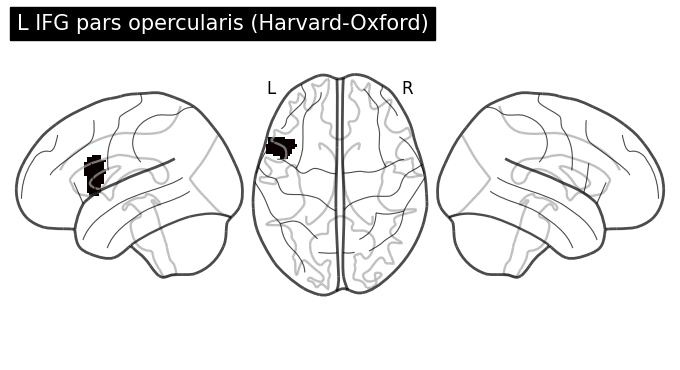

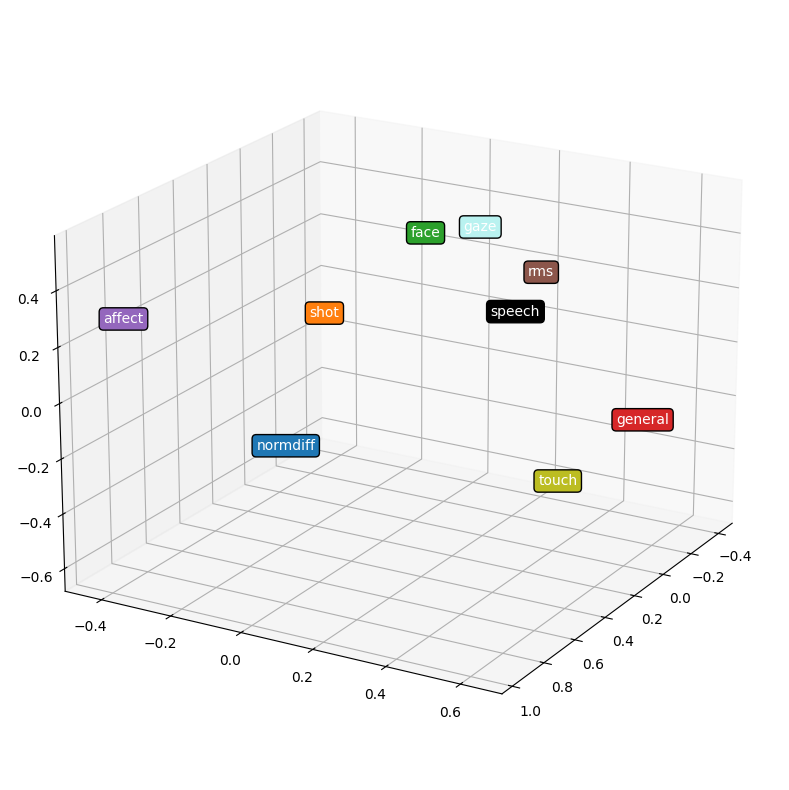

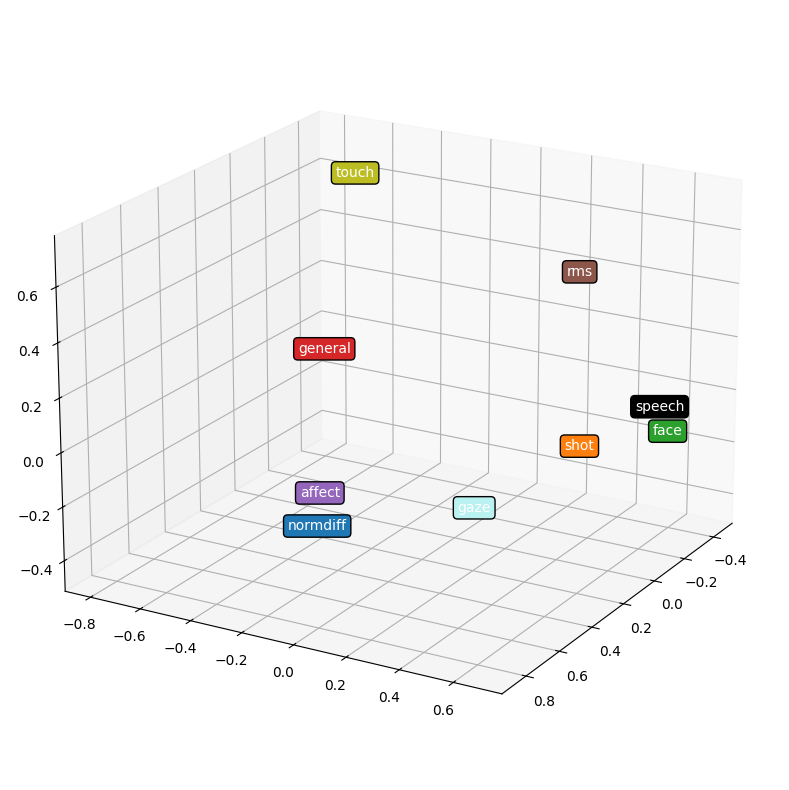

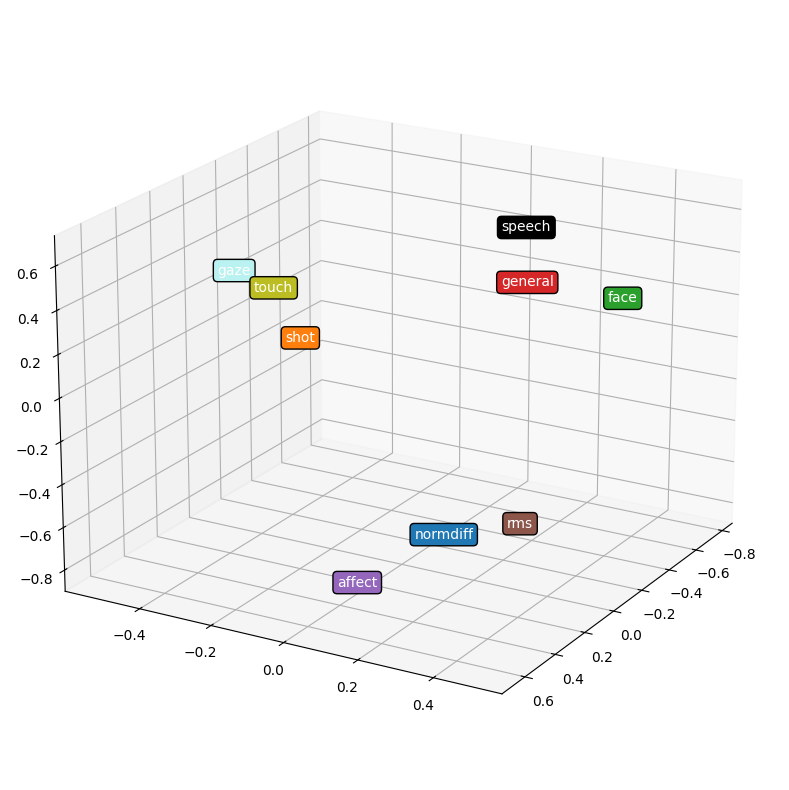

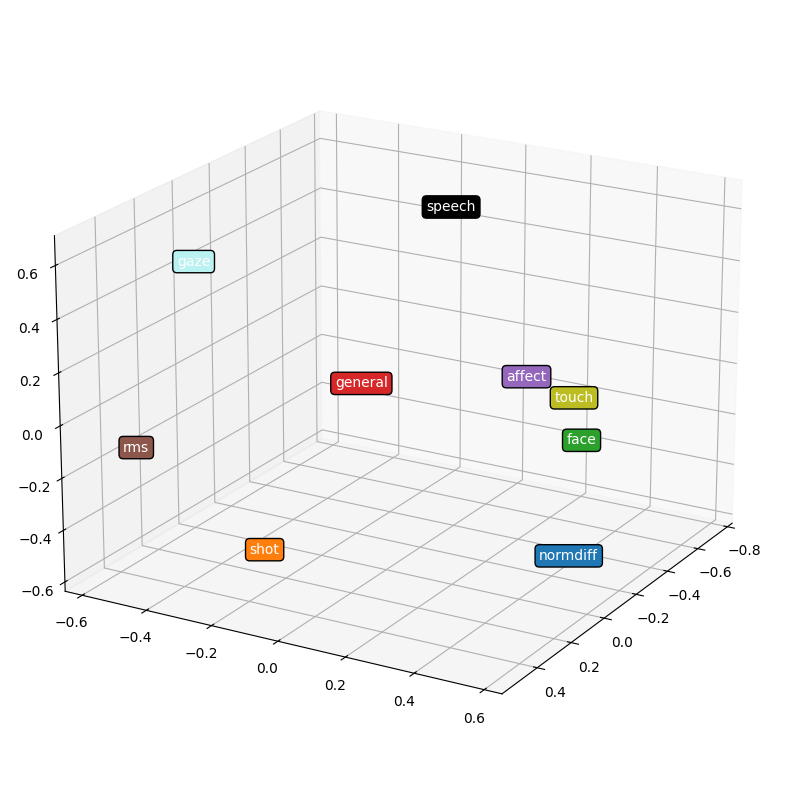

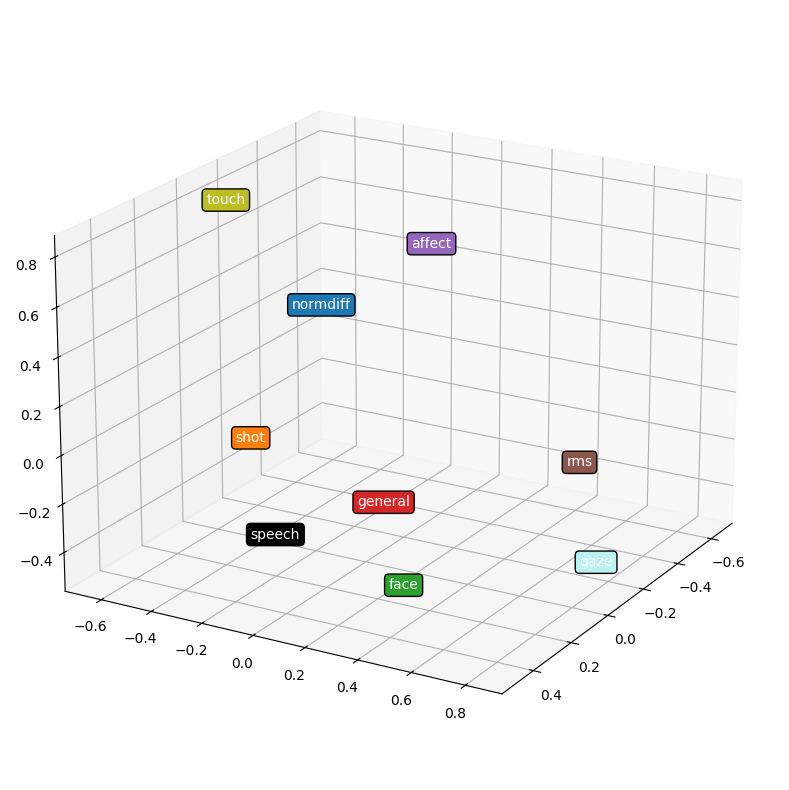

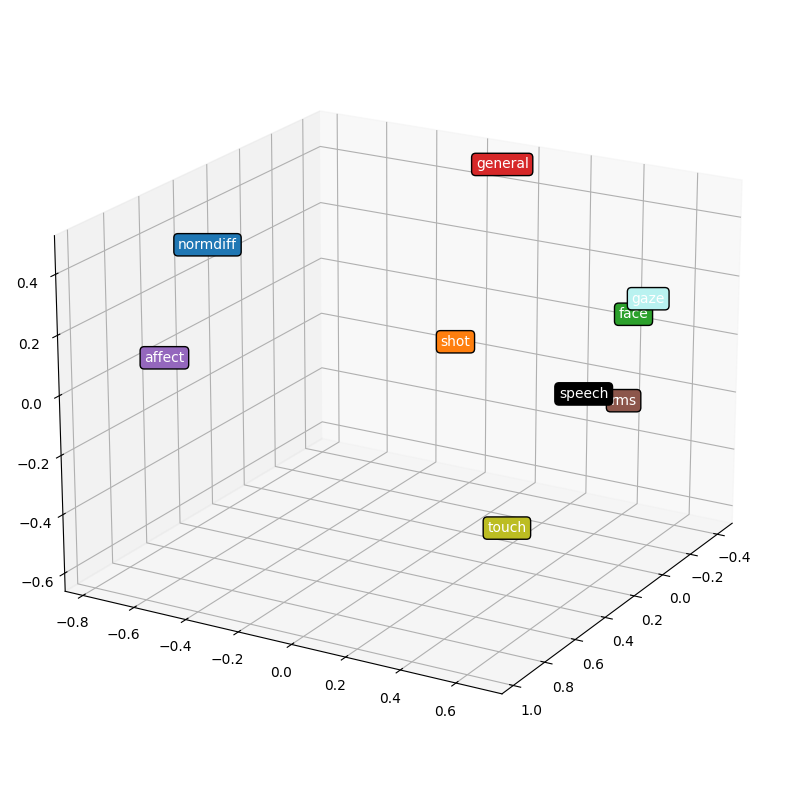

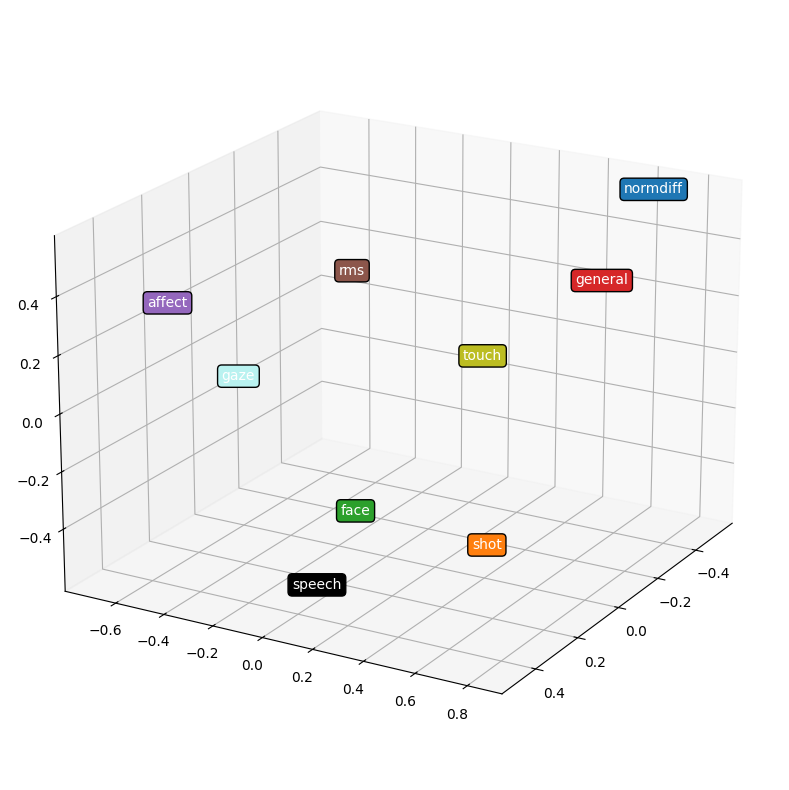

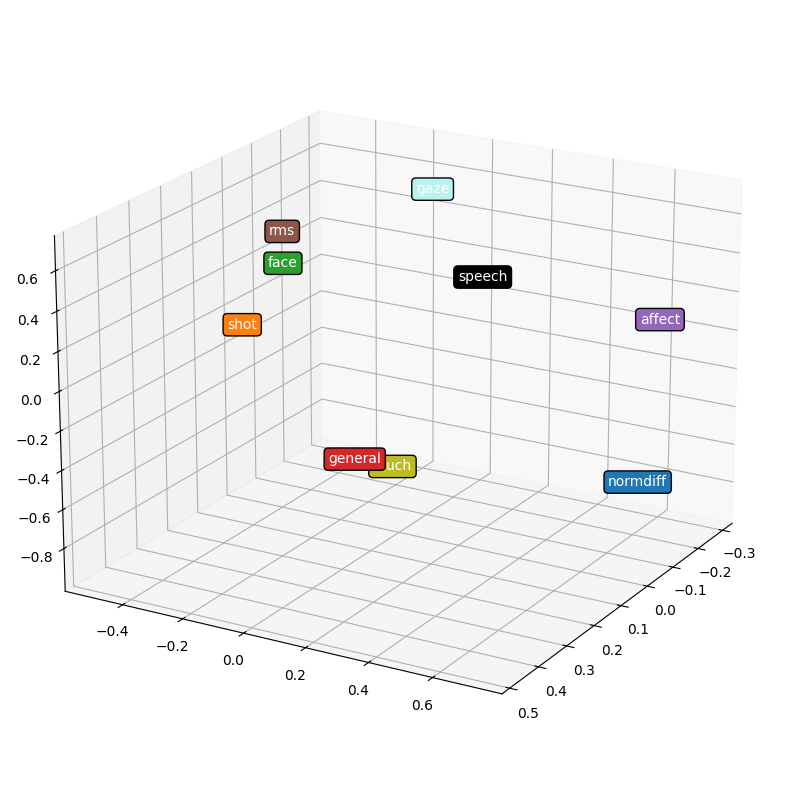

In [20]:
# plotting all subject distances of conditions in a specific roi

plot_glass_brain(mask_x[roi].to_nifti(),title=roi_name, display_mode="lzr")

for i in range(len(all_sub_distance)):
        all_sub_distance[i][roi].labels = cond_list
        #plt.figure()
        all_sub_distance[i][roi].plot_mds(n_components=3,
                                          labels_color = ['tab:blue','tab:orange','tab:green','tab:brown','black'
                                                          ,'#b9f2f0','#bcbd22','#9467bd','#d62728'],
                                          view=(20, 30),normalized_stress='auto')
        plt.tight_layout()

In [14]:
def fisher_r_to_z(r):
    """
    Use Fisher transformation to convert correlation to z score
    arctan turns +/-1 to - inf, we will loop over each r value and transform it
    so we won't divide by 0 later on when correcting for multiple comparisons
    """
    import numpy as np
    import pandas as pd
    
    result = [];
    for x in r:
        if x == -1:
            result.append(np.arctanh(-0.996)) # == 3.106
        elif x == 1:
            result.append(np.arctanh(0.996))  # == 3.106
        else:
            result.append(np.arctanh(x))
        
    return pd.Series(result)

In [15]:
# we will calculate the statistics of all models
con_social_rsa_stats = []; audio_rsa_stats=[]; visual_rsa_stats=[];
for i in all_sub_con_social_rsa:
    # social
    con_social_rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_con_social_rsa[i])))
    # audio
    audio_rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_audio_rsa[i])))
    # visual
    visual_rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_visual_rsa[i])))

fdr p value = 0.041191761647670466


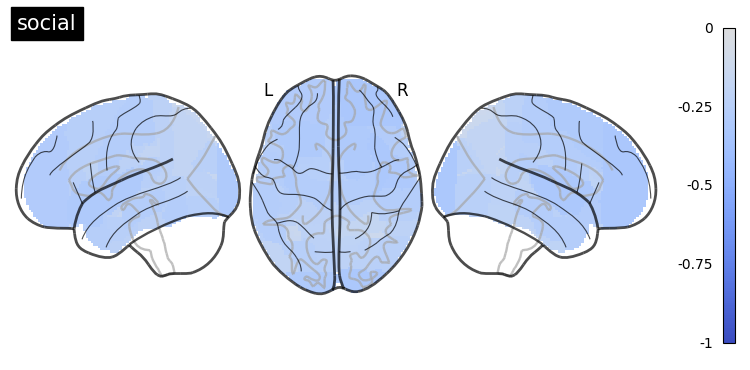

In [16]:
# let's have a look at the results 
# we will try to correct for multiple comparisons using FDR
# if an empty map comes up we can change the threshold to be more liberal

fdr_p = fdr(np.array([x['p'] for x in con_social_rsa_stats]), q=0.05)
print('fdr p value =',fdr_p)

if fdr_p == -1:
    th = 0.05
    print('displaying uncorrected map, thresholded to p<0.05')
else:
    th = fdr_p
    
con_social_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, con_social_rsa_stats)]).sum()
con_social_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, con_social_rsa_stats)]).sum()

thresholded = threshold(con_social_r, con_social_p, thr=th)

plot_glass_brain(thresholded.to_nifti(), cmap='coolwarm',title = 'social',
                 colorbar=True,display_mode="lzr",plot_abs=False,vmin=-1,vmax=1)

fdr p value = 0.010597880423915218


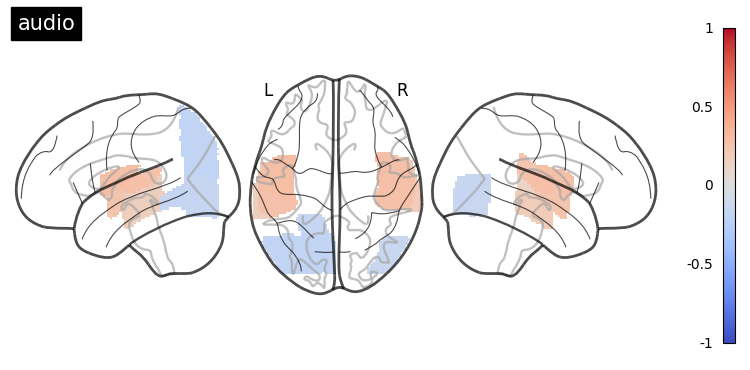

In [17]:
fdr_p = fdr(np.array([x['p'] for x in audio_rsa_stats]), q=0.05)
print('fdr p value =',fdr_p)

if fdr_p == -1:
    th = 0.05
    print('displaying uncorrected map, thresholded to p<0.05')
else:
    th = fdr_p
    
audio_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, audio_rsa_stats)]).sum()
audio_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, audio_rsa_stats)]).sum()

thresholded = threshold(audio_r, audio_p, thr=th)

plot_glass_brain(thresholded.to_nifti(), cmap='coolwarm',title = 'audio',
                 colorbar=True,display_mode="lzr",plot_abs=False,vmin=-1,vmax=1)

fdr p value = -1
displaying uncorrected map, thresholded to p<0.05


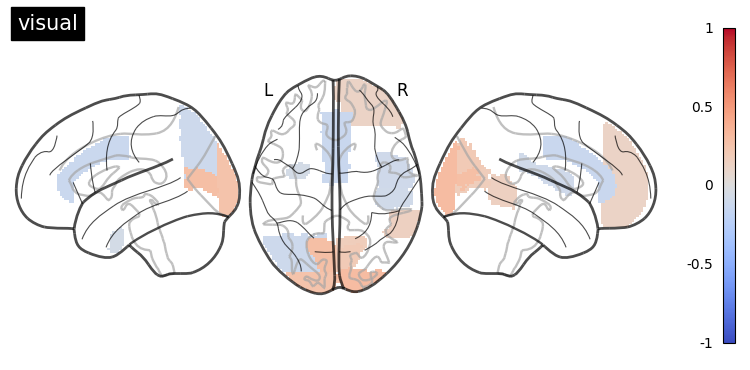

In [18]:
fdr_p = fdr(np.array([x['p'] for x in visual_rsa_stats]), q=0.05)
print('fdr p value =',fdr_p)
if fdr_p == -1:
    th = 0.05
    print('displaying uncorrected map, thresholded to p<0.05')
else:
    th = fdr_p
        
visual_r = Brain_Data([x*y['mean'] for x,y in zip(mask_x, visual_rsa_stats)]).sum()
visual_p = Brain_Data([x*y['p'] for x,y in zip(mask_x, visual_rsa_stats)]).sum()

thresholded = threshold(visual_r, visual_p, thr=th)

plot_glass_brain(thresholded.to_nifti(), cmap='coolwarm',title = 'visual',
                 colorbar=True,display_mode="lzr",plot_abs=False,vmin=-1,vmax=1)

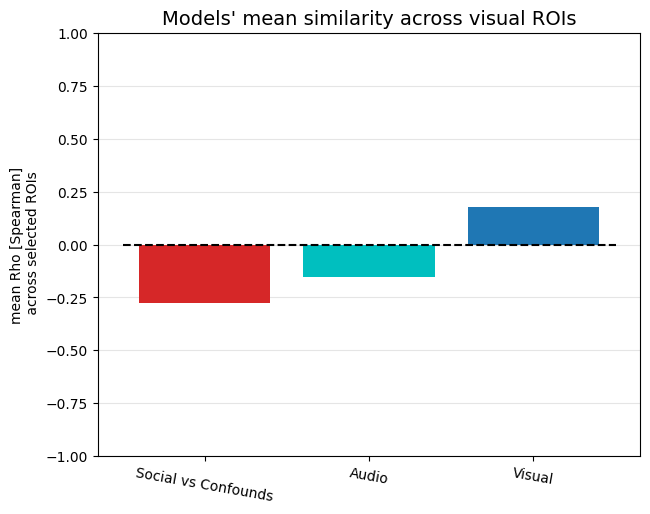

In [31]:
# calculate mean rho (across selected ROIs) - 
# we will use an ROI list that will demostrate our models. we will target our visual model
# occipital poles, occipital fusiform gyrus
ROI_list = [94,95,78,79]

con_social_R_selected = [con_social_rsa_stats[i]['mean'] for i in ROI_list]
audio_R_selected = [audio_rsa_stats[i]['mean'] for i in ROI_list]
visual_R_selected = [visual_rsa_stats[i]['mean'] for i in ROI_list]

# calculate mean correlations and store them in a list
mean_R = [np.mean(con_social_R_selected),
          np.mean(audio_R_selected),
          np.mean(visual_R_selected)]

# name models
model_names = ['Social vs Confounds','Audio','Visual']

# barplot
fig, ax = plt.subplots(figsize=(7,5.5)) # size
bar_colors = ['tab:red','c','tab:blue'] # colors to be used
ax.bar(model_names, mean_R, label=model_names, color=bar_colors,zorder=3) # plot data
# cosmetics
plt.xticks(rotation=-10)
ax.set_ylabel('mean Rho [Spearman]\n across selected ROIs')
plt.ylim([-1,1])
ax.set_title("Models' mean similarity across visual ROIs", fontsize=14)
plt.grid(alpha=0.2,color='gray',axis='y',zorder=0)
plt.hlines(0,-0.5,2.5,colors='black',linestyles='dashed',zorder=4)
plt.show()